In [53]:
# Код для построения сеток
'''
#!python
cubit.cmd('create curve location 0 0 0 location 0 6 0')
cubit.cmd('create curve location 0 0 0 location 8 0 0')
cubit.cmd('create curve location 8 0 0 location 8 2 0')
cubit.cmd('create curve location 8 2 0 location 6 2 0')
cubit.cmd('create curve location 0 6 0 location 6 2 0')
cubit.cmd('create surface curve 1 2 3 4 5 ')

#MESH
cubit.cmd('surface 1 scheme trimesh ')
cubit.cmd('Trimesher surface gradation 1.3')
cubit.cmd('Trimesher geometry sizing on')
cubit.cmd('delete mesh surface 1 propagate')
cubit.cmd('surface 1 scheme trimesh ')
cubit.cmd('Trimesher surface gradation 1.3')
cubit.cmd('Trimesher geometry sizing on')
cubit.cmd('mesh surface 1')
'''

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm_notebook
from itertools import product

import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import seaborn as sns

In [44]:
# Нужна для вычисления процентной разницы между решениями
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def mesh_download(name):
    with open(name) as file:
        allfile = file.readlines()

    # Точки собираем
    for i, val in enumerate(allfile):
        if val == '*NODE\n':
            answer = allfile[i:]
            for i, val in enumerate(answer):
                if val =='$\n':
                    answer = answer[:i]
                    break

    points = np.zeros((len(answer[2:]), 3))
    for i, elem in enumerate(answer[2:]):
        points[i] = [float(val) for val in elem.split(' ') if val != ''][:3]

    points = {int(points[i,0]): (points[i,1], points[i,2]) for i in range(len(points))}

    #  Треугольники собираем
    for i, val in enumerate(allfile):
        if val == '*ELEMENT_SHELL\n':
            answer = allfile[i:]
            for i, val in enumerate(answer):
                if val =='*END\n':
                    answer = answer[:i]
                    break

    triang = np.zeros((len(answer[1:]), 4))
    for i, elem in enumerate(answer[1:]):
        triang[i] = [i+1] + [val for val in elem.split(' ') if val != ''][2:5]
    triang = triang.astype('int')
    triang = {triang[i,0]: (triang[i,1], triang[i,2], triang[i,3]) for i in range(len(triang))}
    
    return points, triang

In [4]:
def interpol_func(ind, points_value, points, triang):
    point_i, point_j, point_k = triang[ind]
    F = points_value[point_i], points_value[point_j], points_value[point_k]
    (X_i, Y_i), (X_j, Y_j), (X_k, Y_k) = points[point_i], points[point_j], points[point_k]
    X = (X_i, X_j, X_k)
    Y = (Y_i, Y_j, Y_k)
    b_ = [Y[i%3] - Y[(i+1)%3] for i in range(1, 4)]
    c_ = [-X[i%3] + X[(i+1)%3] for i in range(1, 4)]
    a_ = [X[i%3] * Y[(i+1)%3] - X[(i+1)%3] * Y[i%3] for i in range(1, 4)]
    A = np.linalg.det(np.array([[1, X_i, Y_i],
                               [1, X_j, Y_j],
                               [1, X_k, Y_k]]))
    N_ = []
    for i in range(3):
        N_.append(lambda x, y, i=i: (a_[i] + b_[i] * x + c_[i] * y) / A)
    return lambda x, y: sum([N_[i](x, y) * F[i] for i in range(3)])

In [5]:
# В дальнейшнем не пригодилась, нашел другие функция для построения треугольников
def plot_triang(i, points, triang, color='green'):
    t1, t2, t3 = triang[i]
    x , y = list(zip(points[t1],points[t2]))
    plt.plot(x,y, color)
    x , y = list(zip(points[t2],points[t3]))
    plt.plot(x,y, color)
    x , y = list(zip(points[t3],points[t1]))
    plt.plot(x,y, color)

In [6]:
#Функция для проверки принадлежности точки треугольнику

def line(coord1, coord2, coord):
    return (coord1[1] - coord2[1]) * coord[0] + (coord2[0] - coord1[0]) * coord[1] + (coord1[0] * coord2[1] -
                                                                              coord1[1] * coord2[0])

def triang_true(i, coord, points, triang):
    t1, t2, t3 = triang[i]
    coord1, coord2, coord3 = points[t1], points[t2], points[t3]
    res1, res2, res3 = line(coord1, coord2, coord), line(coord2, coord3, coord), line(coord3, coord1, coord)
    if (res1 < 0 or np.isclose(res1, 0)) and (res2 < 0 or 
                                              np.isclose(res2, 0)) and (res3 < 0 or np.isclose(res3, 0)):
        return True
    if (res1 > 0 or np.isclose(res1, 0)) and (res2 > 0 or 
                                              np.isclose(res2, 0)) and (res3 > 0 or np.isclose(res3, 0)):
        return True
    return False
    

In [7]:
# Столкнулся с проблемой, что фидесис выдает рандомную нумерацию узлов, 
# поэтому пришлось перенумеровать для удобства
def recount(points, triang):
    res_points = {}
    res_triang = {}
    perehod = {}
    for i, (key, val) in enumerate(points.items()):
        res_points[i] = val
        perehod[key] = i
    for key, (p1, p2, p3) in triang.items():
        res_triang[key-1] = [perehod[p] for p in (p1, p2, p3)]
        
    return res_points, res_triang

In [8]:
# Вычисляет напряжения и деформации по перемещениям и сетке
def deform_napr(U, points, triang):    
    deform = {}
    napr = {}    
    for key, (point1, point2, point3) in triang.items():
        (x1, y1), (x2, y2), (x3, y3) = points[point1], points[point2], points[point3]
        delta = abs((x1 - x3) * (y2 - y3) - (x2 - x3) * (y1 - y3)) # delta = square * 2
        B = np.array([[y2 - y3, 0, y3 - y1, 0, y1 - y2, 0],
                     [0, x3 - x2, 0, x1 - x3, 0, x2 - x1],
                     [x3 - x2, y2 - y3, x1 - x3, y3 - y1, x2 - x1, y1 - y2]]) / delta
        
        ind = [2*point1, 2*point1+1, 2*point2, 2*point2+1, 2*point3, 2*point3+1] 
        deform[key] = B @ U[ind]
        napr[key] = D @ deform[key]
    return napr

In [9]:
# Строит матрицу жесткости и граничные нагрузки, по которым вычисляем перемещения
def k_solver(points, triang):
    K = np.zeros((2 * len(points), 2 * len(points)))
    F = np.zeros(2 * len(points))
    D = np.array([[1, mu , 0],
                 [mu, 1, 0],
                 [0, 0, (1 - mu) / 2]])
    D *= E / (1 - mu**2)
    for key, (point1, point2, point3) in triang.items():
        (x1, y1), (x2, y2), (x3, y3) = points[point1], points[point2], points[point3]
        points_ind = {0:point1, 1:point2, 2:point3}
        delta = abs((x1 - x3) * (y2 - y3) - (x2 - x3) * (y1 - y3)) # delta = square * 2
        B = np.array([[y2 - y3, 0, y3 - y1, 0, y1 - y2, 0],
                     [0, x3 - x2, 0, x1 - x3, 0, x2 - x1],
                     [x3 - x2, y2 - y3, x1 - x3, y3 - y1, x2 - x1, y1 - y2]]) / delta
        
        k_loc = B.T @ D @ B * delta / 2
        for ind in product(range(0, 6, 2), range(0, 6, 2)):
            ind1 = points_ind[ind[0]//2]
            ind2 = points_ind[ind[1]//2]
            K[ind1*2:ind1*2+2, ind2*2:ind2*2+2] += k_loc[ind[0]:ind[0]+2, ind[1]:ind[1]+2]
            
    
        # Задание нагрузок
        for i in range(2):
            for j in range(i+1, 3):
                ind1 = points_ind[i]
                ind2 = points_ind[j]
                coord1, coord2 = points[ind1], points[ind2]
#                 if np.isclose(coord1[0] * coord2[0], 64):
#                     F[[2*ind1, 2*ind2]] += P * abs(coord1[1] - coord2[1]) / 2
                if np.isclose(coord1[1] * coord2[1], 4):
                    if (coord1[0] > 6 or np.isclose(coord1[0], 6)) and (coord1[0] < 8 or 
                                                                        np.isclose(coord1[0], 8)):
                        if (coord2[0] > 6 or np.isclose(coord2[0], 6)) and (coord2[0] < 8 or 
                                                                            np.isclose(coord2[0], 8)):
                            F[[2*ind1+1, 2*ind2+1]] += -P * abs(coord1[0] - coord2[0]) / 2
                    
    for ind, (x, y) in points.items():
        if np.isclose(x, 0):
            K[2*ind] = 0
            K[:, 2*ind] = 0
            K[2*ind, 2*ind] = 1
            F[2*ind] = 0

            K[2*ind+1] = 0
            K[:, 2*ind+1] = 0
            K[2*ind+1, 2*ind+1] = 1
            F[2*ind+1] = 0

        
    U = np.linalg.solve(K, F)
#     print('Error :', np.linalg.norm(K @ U - F), '\n')
    
    return U, deform_napr(U, points, triang)




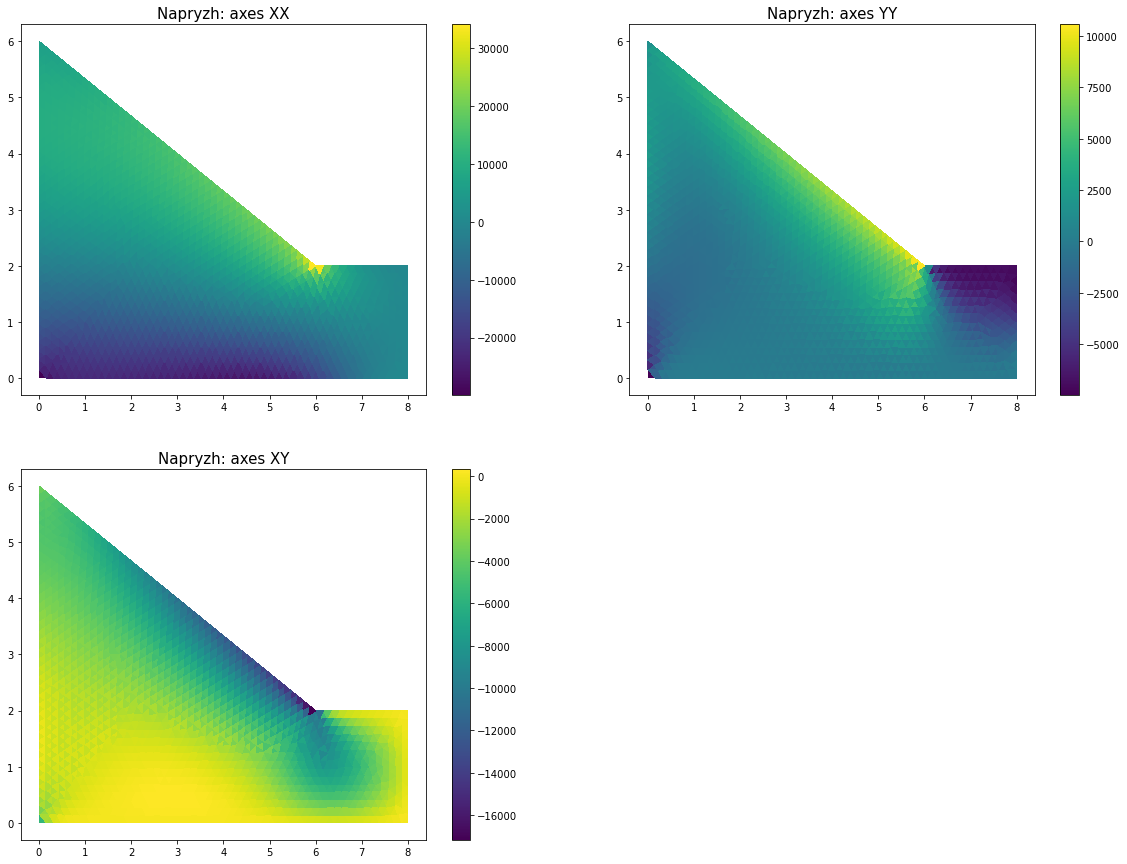

In [45]:
# В этом блоке уже считаем и строим графики напряжений по соотствестующим осям для сетки, где 1312 узлов
P = 7000
E = 20e6
mu = 0.25
t = 2.5

D = np.array([[1, mu , 0],
             [mu, 1, 0],
             [0, 0, (1 - mu) / 2]])
D *= E / (1 - mu**2)

bar_shrink = 0.8

points, triang = mesh_download('my_meshes/6.k')
points, triang = recount(points, triang)

U, napr = k_solver(points, triang)


size = (20, 15)
fig = plt.figure(figsize=size)
x = [point[0] for point in points.values()]
y = [point[1] for point in points.values()]

plt.subplot(2, 2, 1)
plt.title('Napryzh: axes XX', fontsize=15)
plt.tripcolor(x, y, list(triang.values()), [elem[0] for _, elem in napr.items()])
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Napryzh: axes YY', fontsize=15)
plt.tripcolor(x, y, list(triang.values()), [elem[1] for _, elem in napr.items()])
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Napryzh: axes XY', fontsize=15)
plt.tripcolor(x, y, list(triang.values()), [elem[2] for _, elem in napr.items()])
plt.colorbar()

fig.savefig('sol3.png')

In [46]:
def all_results(name):
    points, triang = mesh_download(name)
    points, triang = recount(points, triang)
    return points, triang, k_solver(points, triang)

In [47]:
# По координатам точки ищет нужный треугольник через KD-дерево, затем возвращает искомое напряжение на элементе
def napr_val(x, y, napr, axis, model, points, triang):
    
    ind = model.kneighbors([[x, y]], 7, False).ravel()
    for i in ind:
        if triang_true(i, (x, y), points, triang):
            return napr[i][axis]
    else:
        for i in triang.keys():
            if triang_true(i, (x, y), points, triang):
                return napr[i][axis]

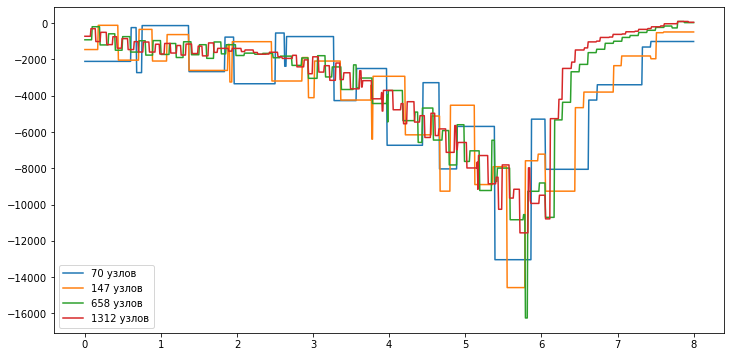

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
axis = 2
# for name in range(1, 7, 2):
# for name in range(4, 7, 1):
for name in [1, 2, 4, 6]:
# for name in [6,]:
    points, triang, (U, napr) = all_results(f'my_meshes/{name}.k')
    centroids = np.zeros((len(triang), 2))
    target = np.arange(len(triang))
    for i in triang.keys():
        t1, t2, t3 = triang[i]
        t1, t2, t3 = points[t1], points[t2], points[t3]
        centroids[i,0] = (t1[0] + t2[0] + t3[0])/3
        centroids[i,1] = (t1[1] + t2[1] + t3[1])/3

    model = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
    model.fit(centroids, target)

    x = np.linspace(0, 8, 1000)
    y = [napr_val(x_i, 1.9, napr, axis, model, points, triang) for x_i in x]
    ax.plot(x, y, label=f'{len(points)} узлов');

    


ax.legend();

fig.savefig('sol1.png')

### Метод согласованных результантов

In [49]:
def CP_method(val, points, triang):
    n = len(points)
    nodeS = np.zeros(shape=(n, n))
    R = np.zeros(n)
    for key, (point1, point2, point3) in triang.items():
        (x1, y1), (x2, y2), (x3, y3) = points[point1], points[point2], points[point3]
        S = abs((x1 - x3) * (y2 - y3) - (x2 - x3) * (y1 - y3)) / 2
        p = [point1, point2, point3]
        R[p] += val[key] * np.abs(S) * 3
        ind = np.array(list(product(p, p)))
        nodeS[ind[:,0], ind[:,1]] += S
    return np.linalg.solve(nodeS, R)

In [50]:
def find_value(x, y, points_value, model, points, triang):
    ind = model.kneighbors([[x, y]], 7, False).ravel()
    for i in ind:
        if triang_true(i, (x, y), points, triang):
            return interpol_func(i, points_value, points, triang)(x, y)
    else:
        for i in triang.keys():
            if triang_true(i, (x, y), points, triang):
                return interpol_func(i, points_value, points, triang)(x, y)

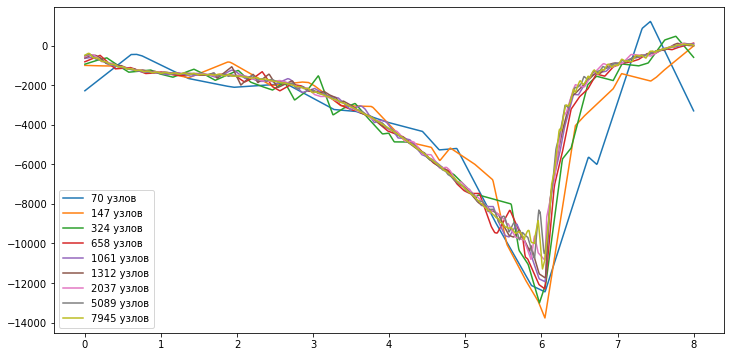

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
# for name in range(5, 7, 1):
# for name in range(4, 7, 1):
# for name in [6, ]:
answers = []
for name in tqdm_notebook([1, 2, 3, 4, 5, 6, 7, 8, 9]):
    points, triang, (U, napr) = all_results(f'my_meshes/{name}.k')
    naprXX = [elem[0] for _, elem in napr.items()]
    naprYY = [elem[1] for _, elem in napr.items()]
    naprXY = [elem[2] for _, elem in napr.items()]
    res = CP_method(naprXY, points, triang)
    res = {i: val for i, val in enumerate(res)}
    
    centroids = np.zeros((len(triang), 2))
    target = np.arange(len(triang))
    for i in triang.keys():
        t1, t2, t3 = triang[i]
        t1, t2, t3 = points[t1], points[t2], points[t3]
        centroids[i,0] = (t1[0] + t2[0] + t3[0])/3
        centroids[i,1] = (t1[1] + t2[1] + t3[1])/3

    model = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree')
    model.fit(centroids, target)

    # мое гладкое решение
    x = np.linspace(0, 8, 1000)
    y = [find_value(x_i, 1.9, res, model, points, triang) for x_i in x]
    answers.append(np.array(y))
    ax.plot(x, y, label=f'{len(points)} узлов');
    
    
ax.legend();

fig.savefig('sol2.png')

In [30]:
# Разница в решениях
for i in range(8):
    print(f'Отличия в процентах между {i+1} и {i+2} решениями {np.round(mape(answers[i], answers[i+1]),2)} %')

Отличия в процентах между 1 и 2 решениями 68.37 %
Отличия в процентах между 2 и 3 решениями 30.33 %
Отличия в процентах между 3 и 4 решениями 30.8 %
Отличия в процентах между 4 и 5 решениями 11.32 %
Отличия в процентах между 5 и 6 решениями 20.14 %
Отличия в процентах между 6 и 7 решениями 43.59 %
Отличия в процентах между 7 и 8 решениями 6.45 %
Отличия в процентах между 8 и 9 решениями 5.87 %


### Конец